In [1]:
import tensorflow as tf

In [2]:
# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
dataset, metadata = tfds.load('mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [5]:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [34]:
#Normalize data
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

#Applying normalize() to train and test set
train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

In [7]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


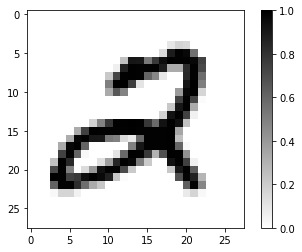

In [8]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

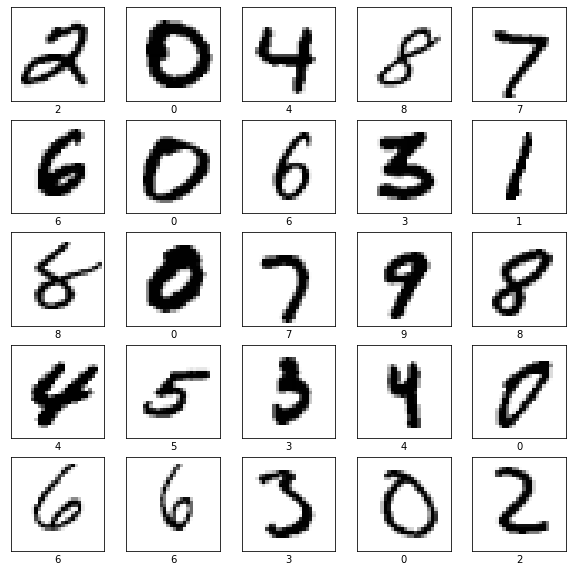

In [ ]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

In [9]:
#network architecture
#convolution 1: Strided Convolution, one 5x5 filters, stride = 1 ('valid' means no padding)
#convolution 2: Strided Convolution, one 5x5 filters, stride = 1 ('valid' means no padding)
#maxpooling: 2x2 filter, Stride 2
#flattening (basically input layer)
#Dense Layer 1 (128 Neurons), Relu
#Dense Layer 2 (10 unit output), Softmax

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(1, (5,5), strides = (1,1), padding='valid', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(1, (5,5), strides = (1,1), padding='valid', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [10]:
#Adam optimizer, learning rate = 0.01 Beta 1 = 0.95, Beta 2 = 0.99
model.compile(tf.keras.optimizers.Adam(
    learning_rate=0.01,
    beta_1=0.95,
    beta_2=0.99),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), # I cant use CategoricalCrossentropy() because the data is loaded in mode 'int'
    metrics=['accuracy'])

In [11]:
#Data: Batch Size 32 (the number of samples to work through before updating the internal model parameters.)
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [12]:
#Fitting model: Epochs = 2
model.fit(train_dataset, epochs=2, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/2
1875/1875 [==============================] - 37s 16ms/step - loss: 0.2548 - accuracy: 0.9200
Epoch 2/2
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1495 - accuracy: 0.9531


In [13]:
#Evaluating model
model.evaluate(test_dataset)

313/313 [==============================] - 4s 13ms/step - loss: 0.1430 - accuracy: 0.9587


[0.1429523080587387, 0.9587000012397766]

In [14]:
#Saving model in .hdf5
model.save('my_model.hdf5')

In [18]:
#Creating a new model from the saved weights
reconstructed_model = tf.keras.models.load_model('my_model.hdf5')

In [19]:
#Testing if the new model from the same weights has the same test set accuracy
reconstructed_model.evaluate(test_dataset)

313/313 [==============================] - 4s 12ms/step - loss: 0.1430 - accuracy: 0.9587


[0.1429523080587387, 0.9587000012397766]

In [17]:
#weights
conv1 = model.layers[0].get_weights()[0]
conv2 = model.layers[1].get_weights()[0]
d1 = model.layers[4].get_weights()[0]
d2 = model.layers[5].get_weights()[0]

#biases
b1 = model.layers[0].get_weights()[1]
b2 = model.layers[1].get_weights()[1]
b3 = model.layers[4].get_weights()[1]
b4 = model.layers[5].get_weights()[1]

to_save = [conv1,conv2,d1,d2,b1,b2,b3,b4]

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 1)         26        
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 1)         26        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 1)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 128)               12928     
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                        

In [20]:
import pickle
with open('weights_demo.pkl', 'wb') as file:
  pickle.dump(to_save, file)

In [21]:
import numpy as np
import gzip

def extract_data(filename, num_images, IMAGE_WIDTH):
    '''
    Extract images by reading the file bytestream. Reshape the read values into a 3D matrix of dimensions [m, h, w], where m 
    is the number of training examples.
    '''
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(IMAGE_WIDTH * IMAGE_WIDTH * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, IMAGE_WIDTH*IMAGE_WIDTH)
        return data

def extract_labels(filename, num_images):
    '''
    Extract label into vector of integer values of dimensions [m, 1], where m is the number of images.
    '''
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [22]:
m =10000
X = extract_data('t10k-images-idx3-ubyte.gz', m, 28)
y_dash = extract_labels('t10k-labels-idx1-ubyte.gz', m).reshape(m,1)
# Normalize the data
X /= 255
test_data = np.hstack((X,y_dash))

X = test_data[:,0:-1]
X = X.reshape(len(test_data), 28, 28,1)
y = test_data[:,-1]

Extracting t10k-images-idx3-ubyte.gz
Extracting t10k-labels-idx1-ubyte.gz


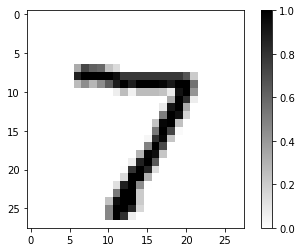

In [23]:
test_image = X[0]

# Plot the image
plt.figure()
plt.imshow(test_image.reshape((28,28)), cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

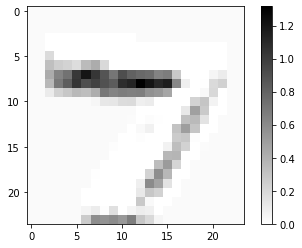

In [33]:
#Output from Convolution Layer 1
from keras.models import Model

XX = model.input
YY = model.layers[0].output
new_model = Model(XX, YY)

test_image = test_image.reshape((1,28,28))
ex_image = tf.convert_to_tensor(test_image)
Xresult = new_model.predict(ex_image)

# Plot the image
plt.figure()
plt.imshow(Xresult.reshape((24,24)), cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

In [32]:
#Output from Convolution Layer 2
from keras.models import Model

XX = model.input
YY = model.layers[1].output
new_model = Model(XX, YY)

test_image = test_image.reshape((1,28,28))
ex_image = tf.convert_to_tensor(test_image)
Xresult_2 = new_model.predict(ex_image)

# Plot the image
plt.figure()
plt.imshow(Xresult_2.reshape((20,20)), cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

tf_after_conv2 = str(Xresult_2.reshape((20,20)))

with open('tf_after_conv2.txt', 'w') as f2:
  s = ''.join(tf_after_conv2)
  f2.write(s)

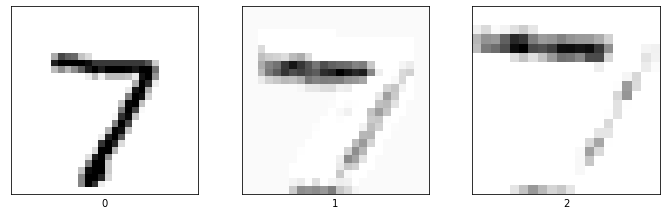

In [27]:
plt.figure(figsize=(20,20))
i = 0
conv_images = [test_image, Xresult, Xresult_2]
for image in conv_images:
    if i == 0:
      image = image.reshape((28,28))
    elif i == 1:
      image = image.reshape((24,24))
    else:
      image = image.reshape((20,20))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(i)
    i += 1
plt.savefig('tensorflow_CNN.png')